In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats
import datetime as dt

In [99]:
calib_year = 2015

In [86]:
case_name = 'hillslope-stream-calib-pfts'

In [113]:
'''Correlation'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

In [88]:
'''Import Hillslope Model Results'''
file_dir = '/glade/derecho/scratch/marielj/archive/' + case_name + '/lnd/hist/'
files = glob(file_dir + case_name + '.clm2.h2.*.nc')
colfiles = glob(file_dir + case_name + '.clm2.h3.*.nc')

data = xr.open_mfdataset(files)
coldata = xr.open_mfdataset(colfiles)

In [89]:
coldata

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         time: 2556, column: 3, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 3)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2011-01-01 00:00:00 ... 2018-01-01 00:0...
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/82)
    hillslope_distance  (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_width     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_area      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_elev      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_slope     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_aspect    (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ...                  ...
    TSA                 (time, pft) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ZWT                 (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ZWT_PERCH           (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 3), meta=np.ndarray>
    H2OSOI              (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
    SOILICE             (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/12/24 12:38:55
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

In [10]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[dt1.DATE.dt.year == calib_year]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)

In [11]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[dt2.Date.dt.year == calib_year]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

In [12]:
'''Convert WTE to WTD'''
wte['WTD'] = -(422.0 - wte.WTE)

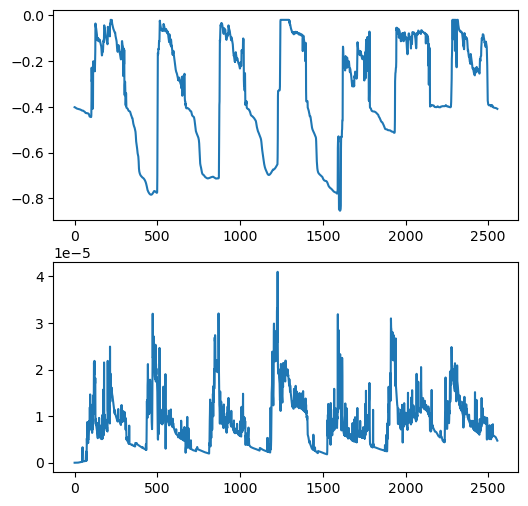

In [90]:
'''General Model Plot'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (6, 6))

#Plot CLM hillslope - column level
ax1.plot(-data.ZWT)

#Plot CLM hillslope - runoff
ax2.plot(data.QRUNOFF)

In [91]:
#Separate out columns
Lagg = coldata.sel(column = 0)
Bog = coldata.sel(column = 1)
Upland = coldata.sel(column = 2)

### Water Table Comparison

In [115]:
meas_wt = wte.WTD
mod_wt = -Bog.ZWT[(coldata.time.dt.year == calib_year)]

In [117]:
rsquared(meas_wt, mod_wt)

0.23634573674352394

In [116]:
nse(mod_wt, meas_wt)

-6.858236908417288

In [118]:
spearman(mod_wt, meas_wt)

0.3509687376094853

### Streamflow comparison

In [110]:
meas_stream = stream.Flow_mms
mod_stream = data.QRUNOFF[(data.time.dt.year == calib_year)].values.reshape(365)

In [111]:
rsquared(meas_stream, mod_stream)

0.35690514074801344

In [112]:
nse(mod_stream, meas_stream)

0.25623736558583443

In [114]:
spearman(mod_stream, meas_stream)

0.6200350034023447

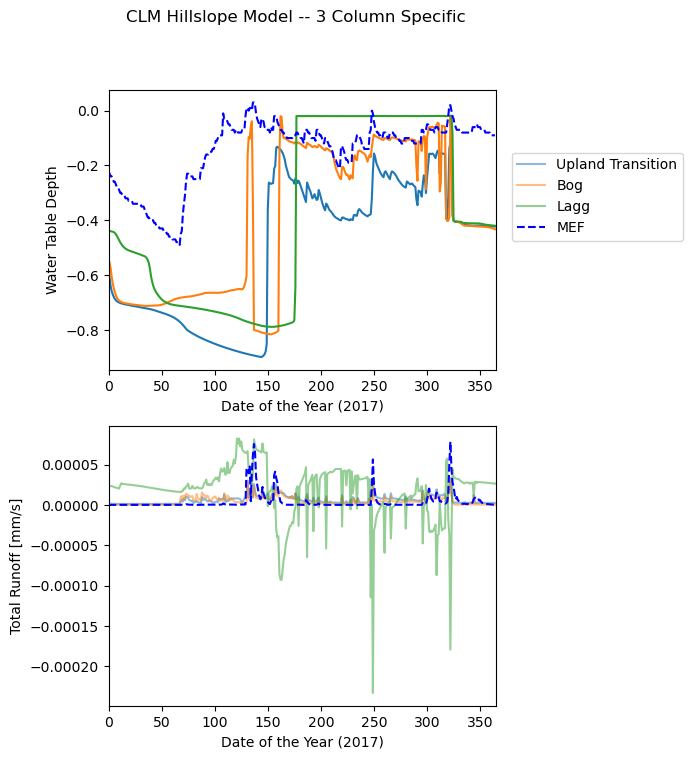

In [120]:
'''Plot model results'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (5, 8))

#Plot CLM hillslope - column level
ax1.plot(-Upland.ZWT[(coldata.time.dt.year == calib_year)], label = 'Upland Transition')
ax1.plot(-Bog.ZWT[(coldata.time.dt.year == calib_year)], label = 'Bog')
ax1.plot(-Lagg.ZWT[(coldata.time.dt.year == calib_year)], label = 'Lagg')

#Plot Marcell data 
ax1.plot(wte.WTD, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth')
ax1.set_xlim(0, 365)

#Plot CLM hillslope - column level
ax2.plot(Upland.QRUNOFF[(coldata.time.dt.year == calib_year)], alpha = 0.5, label = 'Upland Transition')
ax2.plot(Bog.QRUNOFF[(coldata.time.dt.year == calib_year)], alpha = 0.5, label = 'Bog')
ax2.plot(Lagg.QRUNOFF[(coldata.time.dt.year == calib_year)], alpha = 0.5, label = 'Lagg')

#Plot Marcell data 
ax2.plot(stream['Flow_mms'], color = 'blue', linestyle='--', label ='MEF')

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax2.set_ylabel('Total Runoff [mm/s]')
ax2.set_xlim(0, 365)

plt.suptitle('CLM Hillslope Model -- 3 Column Specific')
plt.legend(bbox_to_anchor=(1.5, 2))
plt.show()

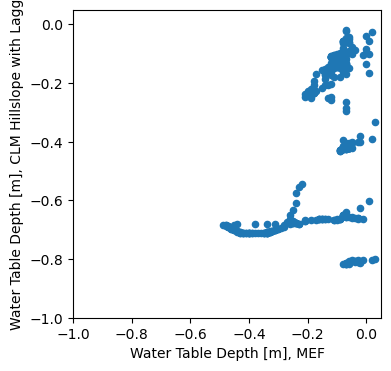

In [121]:
'''Plot model correlation'''
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.scatter(wte.WTD, -Bog.ZWT[(coldata.time.dt.year == calib_year)], s = 20)
ax.set_xlabel('Water Table Depth [m], MEF')
ax.set_ylabel('Water Table Depth [m], CLM Hillslope with Lagg')
ax.set_xlim(-1, 0.05)
ax.set_ylim(-1, 0.05)
ax.set_aspect('equal', 'box')